# <center>Task4: Hotel Sentiment Analysis</center>

#### This task will focus on the customers reviews given at a specific time for 30 hotels/restaurants. The reviews will be classified as Positive, Negative and Neutral based on different types of Sentiment Analysis Models. This will give more insights and help the new cutomers to pick the best hotel during their travel.

In [82]:
%matplotlib inline

import copy
import numpy as np
import pandas as pd
import random
import re
import string

from IPython.display import display, HTML

import matplotlib.pyplot as plt

In [83]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud, STOPWORDS

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

### Run the below cell only once to download nltk data.

In [4]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('sentiwordnet')

In [81]:
import warnings
warnings.filterwarnings('ignore')

## Loading the datasets

### Dataset Information:
1. <b>tourist-accommodation-reviews.xls: Provided by the University</b>
2. <b>positive-words.txt: Downloaded from the internet.</b>
    - (http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html)
    - (https://gist.github.com/mkulakowski2/4289437)
3. <b>negative-words.txt: Downloaded from the internet.</b>
    - (http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html)
    - https://gist.github.com/mkulakowski2/4289441

In [6]:
raw_df = pd.read_csv('dataset/tourist-accommodation-reviews.xls', encoding='cp1252')
positive_df = pd.read_csv('dataset/positive-words.txt', names=['word'])
negative_df = pd.read_csv('dataset/negative-words.txt', names=['word'])

In [7]:
raw_df.head()

,ID,Review Date,Location,Hotel/Restaurant name,Review
0,rn579778340,Reviewed 1 week ago,Kathu,Thong Dee The Kathu Brasserie,Just been for sunday roast lamb and beef truly...
1,rn576350875,Reviewed 3 weeks ago,Kathu,Thong Dee The Kathu Brasserie,"Quietly set off the main road, nice atmosphere..."
2,rn574921678,Reviewed 4 weeks ago,Kathu,Thong Dee The Kathu Brasserie,I made a reservation for a birthday two days i...
3,rn572905503,"Reviewed April 12, 2018",Kathu,Thong Dee The Kathu Brasserie,We visit here regularly and never fail to be i...
4,rn572364712,"Reviewed April 10, 2018",Kathu,Thong Dee The Kathu Brasserie,Visited this wonderful place on my travels and...


In [8]:
raw_df.shape

(53644, 5)

In [9]:
positive_df.tail(3)

,word
2002,zenith
2003,zest
2004,zippy


In [10]:
negative_df.head(3)

,word
0,2-faced
1,2-faces
2,abnormal


In [11]:
df = copy.deepcopy(raw_df)

In [12]:
# changing the column names
df.columns = ['id', 'review_date', 'location', 'hotel_name', 'review']

In [13]:
df.head()

,id,review_date,location,hotel_name,review
0,rn579778340,Reviewed 1 week ago,Kathu,Thong Dee The Kathu Brasserie,Just been for sunday roast lamb and beef truly...
1,rn576350875,Reviewed 3 weeks ago,Kathu,Thong Dee The Kathu Brasserie,"Quietly set off the main road, nice atmosphere..."
2,rn574921678,Reviewed 4 weeks ago,Kathu,Thong Dee The Kathu Brasserie,I made a reservation for a birthday two days i...
3,rn572905503,"Reviewed April 12, 2018",Kathu,Thong Dee The Kathu Brasserie,We visit here regularly and never fail to be i...
4,rn572364712,"Reviewed April 10, 2018",Kathu,Thong Dee The Kathu Brasserie,Visited this wonderful place on my travels and...


### Checking Null Values

In [14]:
df.isnull().sum()

id             0
review_date    0
location       0
hotel_name     0
review         0
dtype: int64

#### There are no null values in the dataset. Therefore, there is no need to remove any of the value or column.

---

### Selection of 30 hotels based on location

In [15]:
df[['id', 'location']].groupby(['location']).count().sort_values(by='id', ascending=False).head(10)

,id
location,
Patong,16403
Karon,5826
Kata Beach,5752
Rawai,3811
Choeng Thale,3378
Phuket Town,3356
Kamala,3162
Mai Khao,2372
Cape Panwa,1500


#### As we can see, patong, karon and kata beach are the two location with most number of reviews. Let's further find if we have 30 hotels at any of these location to do our analysis.

In [16]:
df['location'] = df.location.apply(lambda x: x.lower().strip())

In [17]:
len(df.loc[df.location=='patong'][['hotel_name']].hotel_name.unique())

164

#### We have more than 30 hotels at <b> Patong </b> location. Therefore we have decided to select first 30 random hotels from this location to do sentiment analysis and text mining.

In [18]:
patong_hotel_name = list(set(df.loc[df.location=='patong'][['hotel_name']].hotel_name))

In [19]:
# random.shuffle(patong_hotel_name)
# selected_hotels = patong_hotel_name[0:31]

In [20]:
# print(f'Selected hotels are:\n{selected_hotels}')

In [21]:
selected_hotels = ['EuroThai Restaurant', "Rosco's Restaurant & Sports Bar", 'Tandoor Phuket Indian', 'Malila Restaurant', 'Bubbles Restaurant', 'Roma Ristorante & Pizzeria Da Mauro', 'Song Pee Nong', 'Bucintoro Pizzeria-Ristorante', 'Patong Seafood', 'Da Mario', 'Badsha Indian Food', 'The Pizza Company', 'Chez Nicolas', 'Nanai Steak House and Thai Food', 'YamThai Restaurant', 'No 9 Restaurant', 'Baoli', 'BYD Lofts Restaurant Bistro & Bar', "Naughty Nuri's Phuket", 'Patong Corner Restaurant', 'Natural Efe Macrobiotic World', 'Rustic - Eatery & Bar', 'Blue Horizon - Top Quality Thai Food', 'Sizzle Rooftop Restaurant', 'The Green Gourmet', 'Salute Italian Restaurant', 'Sawasdee', 'Eurasian Restaurant', 'Briley Chicken Rice', 'Soul Curry Restaurant and Bar', 'Wok']

# Exploration of Raw Data

### Checking the total reviews in these hotels

In [22]:
hotels_df = df.loc[df.hotel_name.isin(selected_hotels)]
hotels_df.shape

(3350, 5)

<AxesSubplot: xlabel='hotel_name'>

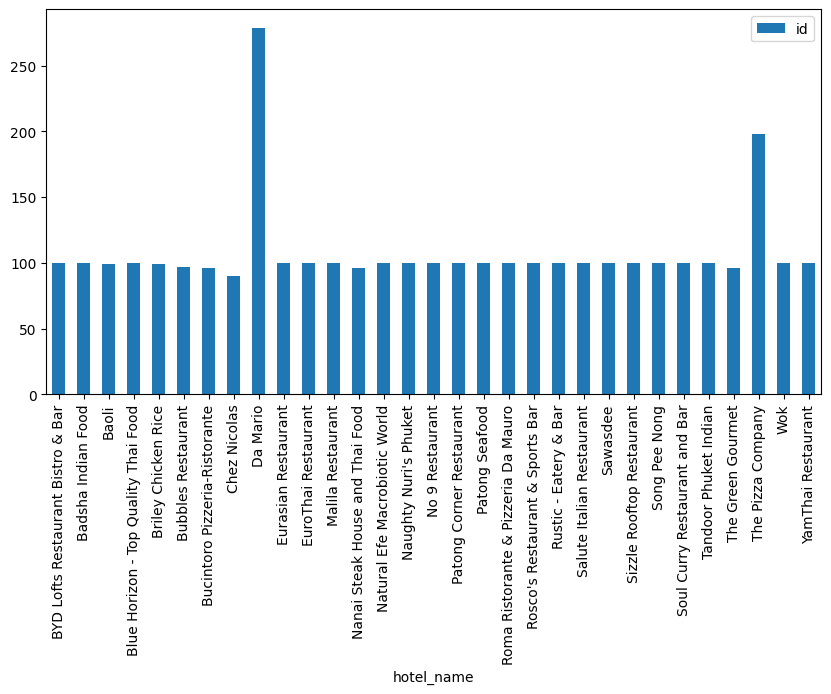

In [23]:
hotels_df[['id', 'hotel_name']].groupby('hotel_name').count().plot(kind='bar', figsize=(10,5))

#### We can see that all the hotels have equal number of reviews i.e 100 except few hotels that hav more than 100 reviews. This is a good sign for us as it will help us to compare similar hotels with equal number of reviews for the customers.

### Checking the reviews words and length distribution

In [24]:
hotels_df['review_words'] = hotels_df.review.apply(lambda x: len(x.split(' ')))
hotels_df['review_length'] = hotels_df.review.apply(lambda x: len(x))

In [25]:
hotels_df.head()

,id,review_date,location,hotel_name,review,review_words,review_length
2190,rn581171309,Reviewed yesterday,patong,Naughty Nuri's Phuket,amazing food. absolutely full of flavour in a ...,27,145
2191,rn581022980,Reviewed 2 days ago,patong,Naughty Nuri's Phuket,Recommended place to fine if you like to eat p...,45,251
2192,rn581022404,Reviewed 2 days ago,patong,Naughty Nuri's Phuket,Went there tonight on recommendation from TA a...,45,243
2193,rn580992792,Reviewed 2 days ago,patong,Naughty Nuri's Phuket,The food was lovely and so were the staff! Whe...,45,233
2194,rn580973038,Reviewed 2 days ago,patong,Naughty Nuri's Phuket,"Best meal and service, food was delicious so m...",22,127


<AxesSubplot: title={'center': 'Distribution of Reviews Words'}, ylabel='Frequency'>

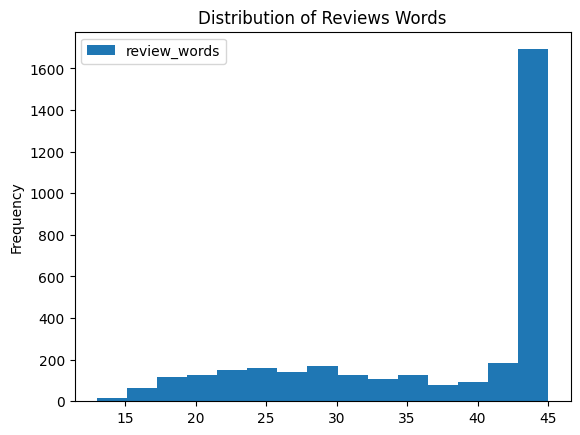

In [26]:
hotels_df[['review_words']].plot(kind='hist', bins=15, title='Distribution of Reviews Words')

#### Most of the reviews have more than 40 words with very few having less than 20 words.

<AxesSubplot: title={'center': 'Distribution of Reviews Length'}, ylabel='Frequency'>

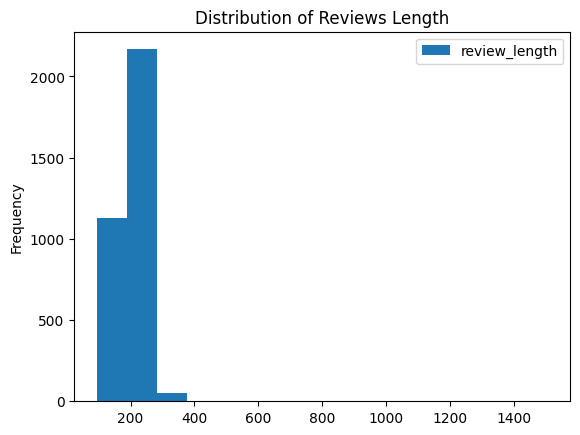

In [27]:
hotels_df[['review_length']].plot(kind='hist', bins=15, title='Distribution of Reviews Length')

#### The characters length of teh reviews seems to lie between 100 and 300 majorly.

### Analysing Bigrams

In [28]:
def plot_bigrams(df_column=None, title=None):
    
    word_data = hotels_df[df_column].tolist()
    word_data = [i.split(' ') for i in word_data]
    word_data = [item for sublist in word_data for item in sublist]
    bigrams = (pd.Series(nltk.ngrams(word_data, 2)).value_counts())[:10]
    bigrams.sort_values().plot.barh(figsize=(5, 5), title=title)
    

def plot_trigrams(df_column=None, title=None):
    
    word_data = hotels_df[df_column].tolist()
    word_data = [i.split(' ') for i in word_data]
    word_data = [item for sublist in word_data for item in sublist]
    trigrams = (pd.Series(nltk.ngrams(word_data, 3)).value_counts())[:10]
    trigrams.sort_values().plot.barh(color='orange', figsize=(5, 5), title=title)

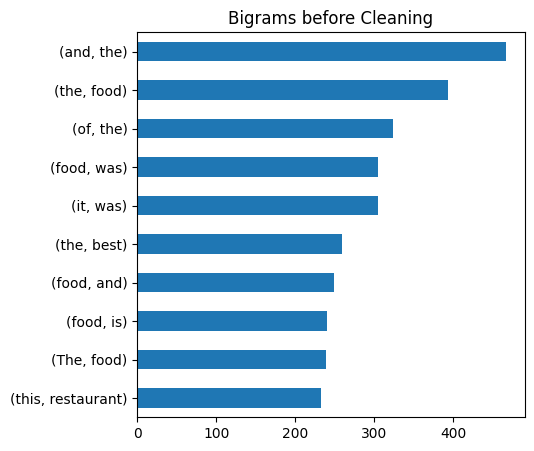

In [29]:
plot_bigrams(df_column='review', title='Bigrams before Cleaning')

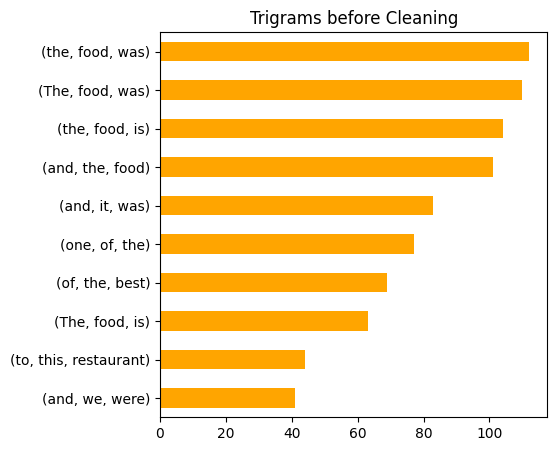

In [30]:
plot_trigrams(df_column='review', title='Trigrams before Cleaning')

#### There is no useful information we can get from these bigrams or trigrams as we haven't cleaned the data yet. These bigrams and trigrams add no value in our analysis and wouldn't help the customers to know about the most common bigrams and trigrams used by the customers. We will plot them again after cleaning all the data. 

### Analysing WordClouds

In [31]:
def make_word_cloud(df=hotels_df, df_column=None, title=None):
    text = " ".join(rev.split()[1] for rev in df[df_column])
    word_cloud = WordCloud(width= 3000, height = 2000, random_state=1, 
                      background_color='white', collocations=False).generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

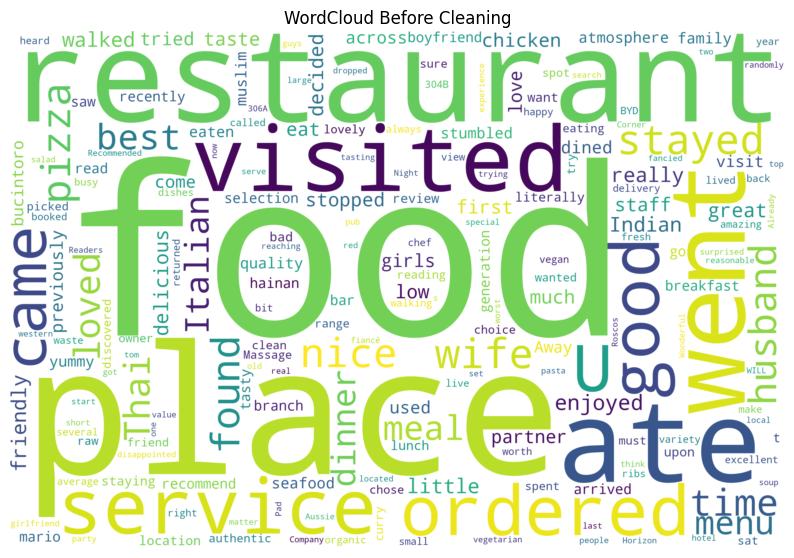

In [32]:
make_word_cloud(df=hotels_df, df_column='review', title='WordCloud Before Cleaning')

---

# Data Preprocessing and Cleaning

In [33]:
hotels_df.head()

,id,review_date,location,hotel_name,review,review_words,review_length
2190,rn581171309,Reviewed yesterday,patong,Naughty Nuri's Phuket,amazing food. absolutely full of flavour in a ...,27,145
2191,rn581022980,Reviewed 2 days ago,patong,Naughty Nuri's Phuket,Recommended place to fine if you like to eat p...,45,251
2192,rn581022404,Reviewed 2 days ago,patong,Naughty Nuri's Phuket,Went there tonight on recommendation from TA a...,45,243
2193,rn580992792,Reviewed 2 days ago,patong,Naughty Nuri's Phuket,The food was lovely and so were the staff! Whe...,45,233
2194,rn580973038,Reviewed 2 days ago,patong,Naughty Nuri's Phuket,"Best meal and service, food was delicious so m...",22,127


#### Column review_date, location, review_words and review_length are of no use to us now. Hence dropping these columns.

In [34]:
hotels_df = hotels_df.drop(['review_date', 'location', 'review_words', 'review_length'], axis=1)

In [35]:
hotels_df.head(2)

,id,hotel_name,review
2190,rn581171309,Naughty Nuri's Phuket,amazing food. absolutely full of flavour in a ...
2191,rn581022980,Naughty Nuri's Phuket,Recommended place to fine if you like to eat p...


In [36]:
stop_words = set(stopwords.words('english'))
word_lemmatizer = WordNetLemmatizer()

In [37]:
def clean_text(txt):
    """
    This function applies text cleaning steps to raw reviews of the hotel.
    """
    
    try:
        # Convert text to lowercase
        text = txt.lower()

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove punctuation
        text = text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove whitespaces
        text = text.strip()

        # Tokenization and Remove stop words
        tokens = word_tokenize(text)
        result = [i for i in tokens if not i in stop_words]

        # Lemmatization
        lemm_text = [word_lemmatizer.lemmatize(word) for word in result]
        
        return " ".join(lemm_text)
    except Exception as e:
        print('Error in clean_text function', str(e))

In [38]:
hotels_df['clean_review'] = hotels_df.review.apply(lambda x: clean_text(x))

In [39]:
hotels_df.head()

,id,hotel_name,review,clean_review
2190,rn581171309,Naughty Nuri's Phuket,amazing food. absolutely full of flavour in a ...,amazing food absolutely full flavour cool loca...
2191,rn581022980,Naughty Nuri's Phuket,Recommended place to fine if you like to eat p...,recommended place fine like eat pork joint ven...
2192,rn581022404,Naughty Nuri's Phuket,Went there tonight on recommendation from TA a...,went tonight recommendation ta must say ’ fuss...
2193,rn580992792,Naughty Nuri's Phuket,The food was lovely and so were the staff! Whe...,food lovely staff came cocktail shaking dance ...
2194,rn580973038,Naughty Nuri's Phuket,"Best meal and service, food was delicious so m...",best meal service food delicious many choice r...


#### We can clearly see the difference between the raw review and clean_review. All the text cleaning and preprocessing steps have been applied to get clean_review.

----

## Bigrams and Trigram plots after Text Cleaning.

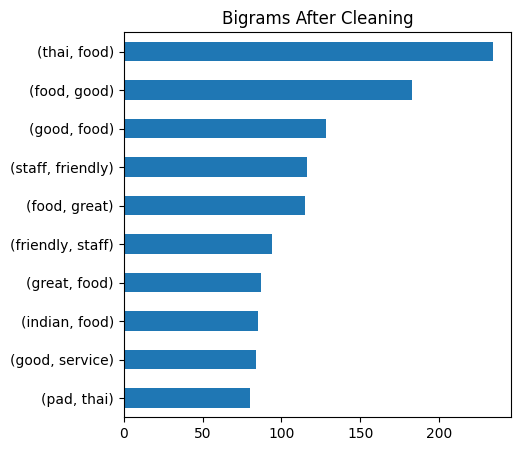

In [40]:
plot_bigrams(df_column='clean_review', title='Bigrams After Cleaning')

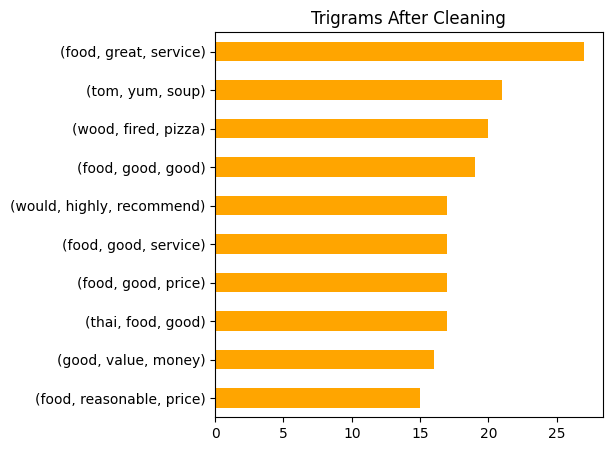

In [41]:
plot_trigrams(df_column='clean_review', title='Trigrams After Cleaning')

#### The bigrams and trigrams makes much more sense after cleaning the reviews from unncessary noise (disturbance). As we can see, bigrams such as (thai, food), (good, service), (inddian, food) are mostly used by the customers while reviewing these 30 restaurants.</b>
#### Trigrams such as (food, great, service), (wood, fired, pizza) gives us some information about specific category of pizza, that customers liked the most. We can see that trigram (food, reasonable, price) shows happiness of the customers about the genuine and cheap price they paid for the food.

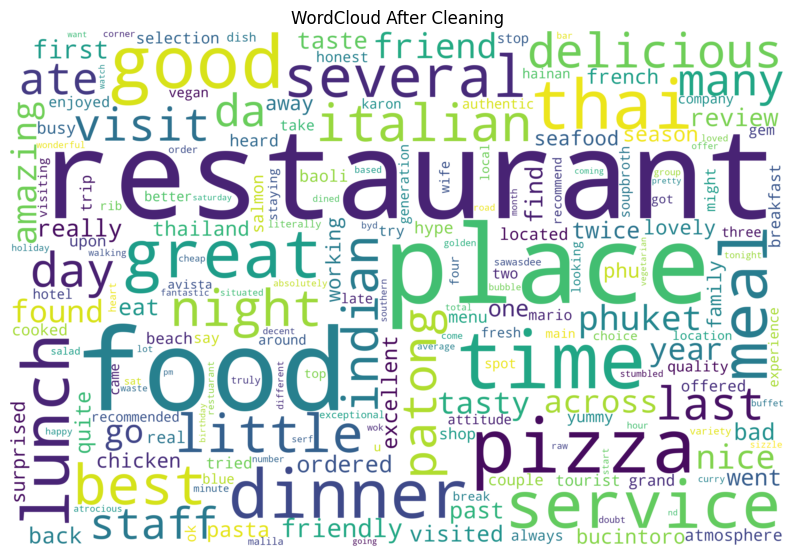

In [42]:
make_word_cloud(df=hotels_df, df_column='clean_review', title='WordCloud After Cleaning')

---

# <center>Model Building</center>

---

## Sentiment Analyser Lexicon Based Model

In [43]:
hotels_df.head(3)

,id,hotel_name,review,clean_review
2190,rn581171309,Naughty Nuri's Phuket,amazing food. absolutely full of flavour in a ...,amazing food absolutely full flavour cool loca...
2191,rn581022980,Naughty Nuri's Phuket,Recommended place to fine if you like to eat p...,recommended place fine like eat pork joint ven...
2192,rn581022404,Naughty Nuri's Phuket,Went there tonight on recommendation from TA a...,went tonight recommendation ta must say ’ fuss...


In [44]:
def sentiment_score_builder(review):
    try:
        positive_word_count = 0
        negative_word_count = 0

        positive_words = len(set(review.split()).intersection(set(positive_df.word)))
        negative_words = len(set(review.split()).intersection(set(negative_df.word)))

        positive_word_count = positive_word_count + positive_words
        negative_word_count = negative_word_count + negative_words

        review_score = positive_word_count - negative_word_count

        return review_score

    except Exception as e:
        print('Error in the sentiment_score_builder function', str(e))
        return 0


In [45]:
def assign_sentiment_label(sentiment_score):
    if sentiment_score < 0:
        return 'negative'
    elif sentiment_score == 0:
        return 'neutral'
    else:
        return 'positive'

In [46]:
hotels_df['sentiment_score'] = hotels_df.clean_review.apply(lambda x: sentiment_score_builder(x))

In [47]:
hotels_df['sentiment'] = hotels_df.sentiment_score.apply(lambda x: assign_sentiment_label(x))

In [48]:
hotels_df.head()

,id,hotel_name,review,clean_review,sentiment_score,sentiment
2190,rn581171309,Naughty Nuri's Phuket,amazing food. absolutely full of flavour in a ...,amazing food absolutely full flavour cool loca...,2,positive
2191,rn581022980,Naughty Nuri's Phuket,Recommended place to fine if you like to eat p...,recommended place fine like eat pork joint ven...,5,positive
2192,rn581022404,Naughty Nuri's Phuket,Went there tonight on recommendation from TA a...,went tonight recommendation ta must say ’ fuss...,1,positive
2193,rn580992792,Naughty Nuri's Phuket,The food was lovely and so were the staff! Whe...,food lovely staff came cocktail shaking dance ...,2,positive
2194,rn580973038,Naughty Nuri's Phuket,"Best meal and service, food was delicious so m...",best meal service food delicious many choice r...,3,positive


---

## Sentiment Analyser with vaderSentiment

In [49]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(review):
    analysed_review = analyzer.polarity_scores(review)
    return analysed_review['compound']

# function to analyse

def vader_sentiment_label(comp):
    if comp >= 0.5:
        return 'positive'
    elif comp <= -0.5 :
        return 'negative'
    else:
        return 'neutral'

In [50]:
hotels_df['vader_sentiment'] = hotels_df.clean_review.apply(get_vader_sentiment)
hotels_df['vader_analysis'] = hotels_df.vader_sentiment.apply(vader_sentiment_label)
hotels_df.head()

,id,hotel_name,review,clean_review,sentiment_score,sentiment,vader_sentiment,vader_analysis
2190,rn581171309,Naughty Nuri's Phuket,amazing food. absolutely full of flavour in a ...,amazing food absolutely full flavour cool loca...,2,positive,0.8876,positive
2191,rn581022980,Naughty Nuri's Phuket,Recommended place to fine if you like to eat p...,recommended place fine like eat pork joint ven...,5,positive,0.8979,positive
2192,rn581022404,Naughty Nuri's Phuket,Went there tonight on recommendation from TA a...,went tonight recommendation ta must say ’ fuss...,1,positive,0.6369,positive
2193,rn580992792,Naughty Nuri's Phuket,The food was lovely and so were the staff! Whe...,food lovely staff came cocktail shaking dance ...,2,positive,0.8591,positive
2194,rn580973038,Naughty Nuri's Phuket,"Best meal and service, food was delicious so m...",best meal service food delicious many choice r...,3,positive,0.8360,positive


---

## Sentiment Analyser with TextBlob

In [51]:
def get_polarity(review):
    return TextBlob(review).sentiment.polarity

In [52]:
hotels_df['Polarity'] = hotels_df.clean_review.apply(get_polarity) 
hotels_df['textBlob_Analysis'] = hotels_df.Polarity.apply(assign_sentiment_label)
hotels_df.head()

,id,hotel_name,review,clean_review,sentiment_score,sentiment,vader_sentiment,vader_analysis,Polarity,textBlob_Analysis
2190,rn581171309,Naughty Nuri's Phuket,amazing food. absolutely full of flavour in a ...,amazing food absolutely full flavour cool loca...,2,positive,0.8876,positive,0.525000,positive
2191,rn581022980,Naughty Nuri's Phuket,Recommended place to fine if you like to eat p...,recommended place fine like eat pork joint ven...,5,positive,0.8979,positive,0.225758,positive
2192,rn581022404,Naughty Nuri's Phuket,Went there tonight on recommendation from TA a...,went tonight recommendation ta must say ’ fuss...,1,positive,0.6369,positive,1.000000,positive
2193,rn580992792,Naughty Nuri's Phuket,The food was lovely and so were the staff! Whe...,food lovely staff came cocktail shaking dance ...,2,positive,0.8591,positive,0.350000,positive
2194,rn580973038,Naughty Nuri's Phuket,"Best meal and service, food was delicious so m...",best meal service food delicious many choice r...,3,positive,0.8360,positive,0.675000,positive


---

# Results Analysis

#### We have built three different models to do the sentiment analsyis of the customers reviews and categorize the reviews into three categories (positive, negative and neutral).

1. <b>Lexicon Based Model:</b> The difference of postive and negative word count in a review gives us the overall score of the review.
2. <b>TextBblob Model:</b> We have used TextBlob library and used sentiment.polarity method to get the overall polarity of the review.
3. <b>VaderSentiment Model:</b> We have used  vaderSentiment library and SentimentIntensityAnalyzer method to get the overall polarity of the review.

In [53]:
lexicon_counts = hotels_df.sentiment.value_counts()
tb_counts = hotels_df.textBlob_Analysis.value_counts()
vader_counts = hotels_df.vader_analysis.value_counts()

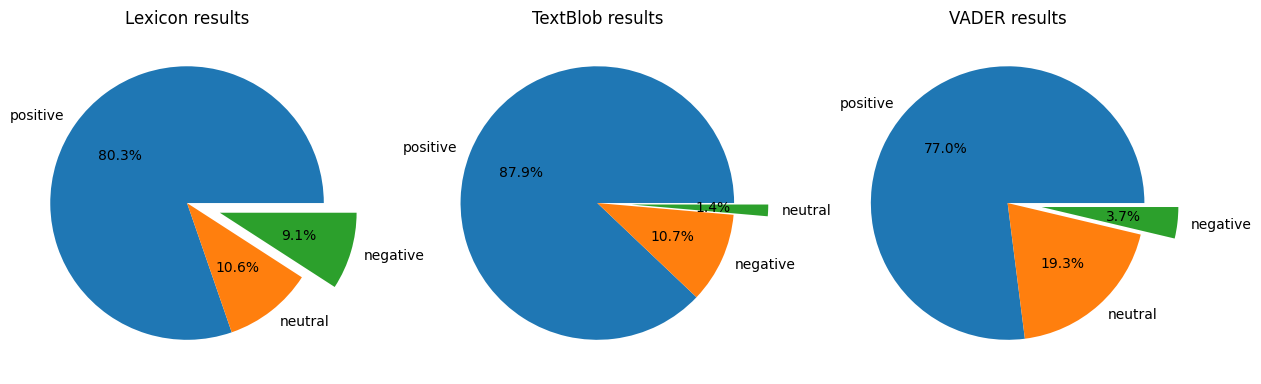

In [54]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
plt.title("Lexicon results")
plt.pie(lexicon_counts.values, labels = lexicon_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

plt.subplot(1,3,2)
plt.title("TextBlob results")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

plt.subplot(1,3,3)
plt.title("VADER results")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

plt.show()

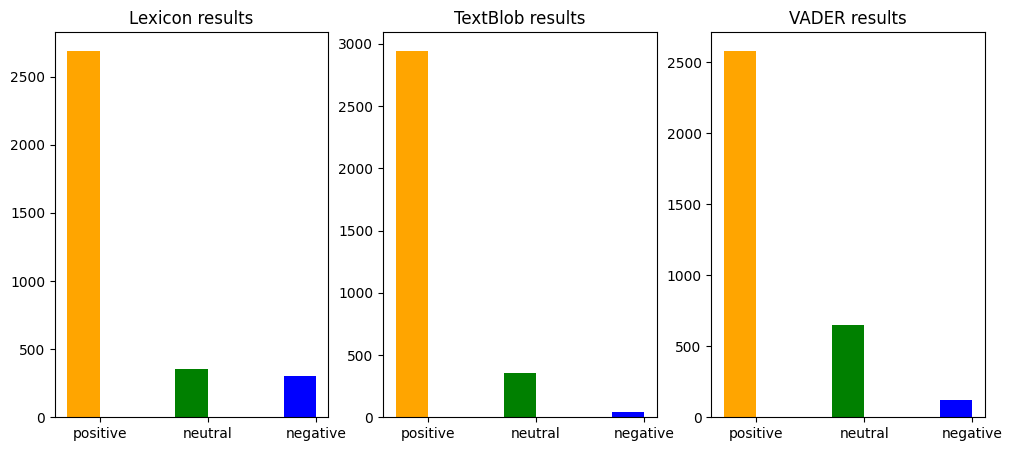

In [55]:
labels = ['positive', 'neutral', 'negative']

lexicon_values = list(lexicon_counts.values)
textblob_values = list(tb_counts.values)
vader_values = list(vader_counts.values)

x = np.arange(len(labels))
width = 0.3

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title("Lexicon results")
plt.bar(x-width/2, lexicon_values, width, color=['orange', 'green', 'blue'])
plt.xticks([0,1,2], labels)  

plt.subplot(1,3,2)
plt.title("TextBlob results")
plt.bar(x-width/2, textblob_values, width, color=['orange', 'green', 'blue'])
plt.xticks([0,1,2], labels)


plt.subplot(1,3,3)
plt.title("VADER results")
plt.bar(x-width/2, vader_values, width, color=['orange', 'green', 'blue'])
plt.xticks([0,1,2], labels)

plt.show()

#### From the above pie charts and bar plot comparisons, it could be infered that most of the reviews given by the customers are positive. On the other hand, the number of negative and neutral reviews are nearly equals to each other when compared to positive reviews.

<b> We have build our own Lexicon based model that performs quite well when compared to third party libraries used for sentiment analysis such as Vader and TextBlob. Results for positive reviews are very close lexicon model is compared with Vader as both of the models indentify approximately equal numbers of positive reviews.<b></br>
<b>On the other hand, Vader classify more neutral reviews and less negative reviews then Lexicon model. This wouldn't affect our final analysis as we are determined to provide best hotel recommendation for the new customers as per the positive reviews about the venue. Hence, we will go with our own built Lexicon based sentiment model to further identify the best hotel. <b>

---

## Best Hotels Analysis

### Ranking of All Hotels
#### Although, most of the hotels have positive reviews, it would be interesting for the new customers to know the best restaurant out of these 30 hotels.

In [79]:
def get_all_hotels_ranking(clean_reviews):
    try:
        
        positive_word_count = 0
        negative_word_count = 0
    
        for review in clean_reviews:
    
            positive_words = len(set(review.split()).intersection(set(positive_df.word)))
            negative_words = len(set(review.split()).intersection(set(negative_df.word)))

            positive_word_count = positive_word_count + positive_words
            negative_word_count = negative_word_count + negative_words

            
        total_detected_words = positive_word_count + negative_word_count
        perc_pos = round((positive_word_count*100)/total_detected_words, 2)
        perc_neg = round((negative_word_count*100)/total_detected_words, 2)
      
        return perc_pos, perc_neg
            
    except Exception as e:
        print('Error in the get_all_hotels_ranking.')

def loop_hotels(hotels_df):
    try:
        hotel_list = list()
        
        for hotel in list(hotels_df.hotel_name.unique()):
            clean_reviews = list(hotels_df.loc[hotels_df.hotel_name==hotel].clean_review)
            perc_pos, perc_neg = get_all_hotels_ranking(clean_reviews)
            hotel_list.append((hotel, perc_pos, perc_neg))
        
        columns = ('hotel_name', 'positive_reviews', 'negative_reviews')
        return pd.DataFrame(hotel_list, columns=columns).sort_values(by='positive_reviews', ascending=False)
        
    except Exception as e:
        print('Error in the loop_hotels fucntion', str(e))

In [84]:
hotel_sorted_df = loop_hotels(hotels_df)
display(HTML(hotel_sorted_df.to_html(index=False)))

hotel_name,positive_reviews,negative_reviews
Salute Italian Restaurant,93.13,6.87
BYD Lofts Restaurant Bistro & Bar,91.00,9.00
Natural Efe Macrobiotic World,90.14,9.86
Soul Curry Restaurant and Bar,89.61,10.39
Bubbles Restaurant,89.39,10.61
Sawasdee,89.10,10.90
Sizzle Rooftop Restaurant,89.07,10.93
Bucintoro Pizzeria-Ristorante,88.44,11.56
Nanai Steak House and Thai Food,88.05,11.95
Patong Corner Restaurant,87.10,12.90


#### Salute Italian Restaurant,  BYD Lofts Restaurant Bistro & Bar and Natural Efe Macrobiotic World are the best 3 restaurants with regards to the positive reviews given by the customers.

#### Malila Restaurant, Patong Seafood and Chez Nicolas are the worst three restaurants as per the customers reviews.

---

### Analysing WordCloud for Best Restaurant

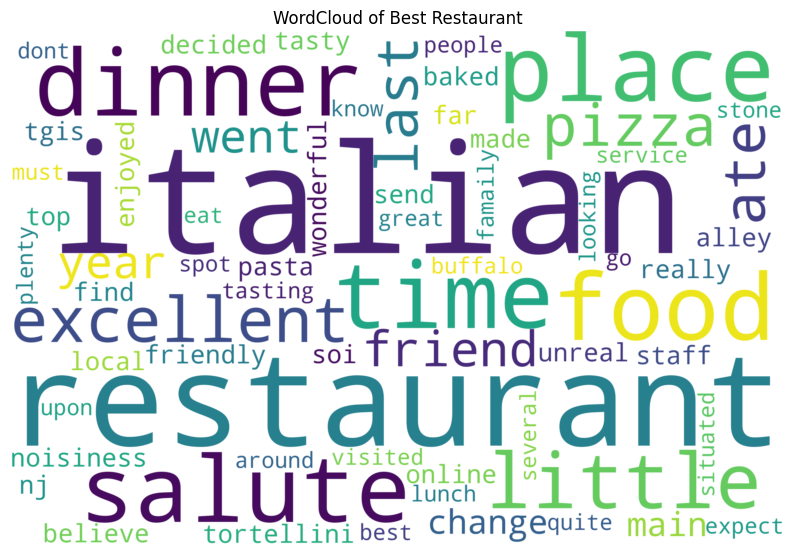

In [78]:
best_hotel_df = hotels_df.loc[hotels_df.hotel_name=='Salute Italian Restaurant']
make_word_cloud(df=best_hotel_df, df_column='clean_review', title='WordCloud of Best Restaurant')

#### We can interpret that Salute Italian Restaurant is an Italian restaurant as most of the reviews have mentioned this word. Words like tasty, pizza and foodprice defines the food with great price. Additionally words such as great and atmosphere shows about people enjoying the ambience of this restaurant...

---

# <center>End of Notebook</center>

----